In [ ]:
from tensorflow import keras
import numpy as np
import pandas as pd

In [ ]:
TPS_file_path = '../input/tabular-playground-series-jan-2021/train.csv'
TPS_data = pd.read_csv(TPS_file_path)
TPS_data.shape

In [ ]:
TPS_data.head()

In [ ]:
TPS_data.drop('id', axis=1, inplace=True)
TPS_data.head()

In [ ]:
from sklearn.model_selection import train_test_split

train_set, valid_set = train_test_split(TPS_data, test_size=0.2, random_state=42, shuffle=True)

[train_set.shape, valid_set.shape]

In [ ]:
X_train = train_set.drop('target', axis=1)
X_valid = valid_set.drop('target', axis=1)

y_train = train_set.target
y_valid = valid_set.target

In [ ]:
X_train.hist(figsize=(20,15), bins=50)

In [ ]:
X_train.hist(column='cont1', bins=50)

In [ ]:
X_train.max().sort_values(ascending=False)

In [ ]:
cols = X_train.columns
cols

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_valid = pd.DataFrame(scaler.transform(X_valid))

In [ ]:
X_train.columns = cols
X_train.head()

In [ ]:
X_train.max().sort_values(ascending=False)

# Budujemy zaawansowany model

In [ ]:
keras.backend.clear_session() # czyścimy pamięć z modeli, wag,...

In [ ]:
import tensorflow as tf

# budujemy funkcję straty rmse
# w podobny sposób możemy budować każdy inny obiekt (modele, warstwy, funkcje aktywacji,...)
# wszystkie operacje wykonujemy na tensorach (specjalny rodzaj danych stworzony przez TensorFlow)

def rmse_fn(y_true, y_pred):
    error = tf.subtract(y_true, y_pred)
    squared_error = tf.square(error)
    MSE = tf.reduce_mean(squared_error)
    RMSE = tf.sqrt(MSE)
    return RMSE

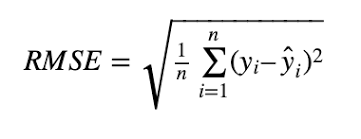

In [ ]:
# tworzymy funkcję budującą model, poneważ chcemy tworzyć wiele modeli z różnymi hiperparametrami

from tensorflow.keras import layers

def build_model(n_hidden=1, n_neurons=30, learning_rate=1e-2):
    model = keras.models.Sequential()
    model.add(layers.InputLayer(input_shape=[14]))
    model.add(layers.BatchNormalization())
    for layer in range(n_hidden):
        model.add(layers.Dense(n_neurons, kernel_initializer="he_normal"))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation("elu"))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1))
    optimizer = keras.optimizers.Nadam(lr=learning_rate)
    model.compile(loss=rmse_fn, optimizer=optimizer)
    return model

Przetrenowanie - model doskonale dopasowuje się do zbioru uczącego, nie potrafi jednak poprawnie przewidywać z danych testowych, spowodowane zbyt dużą liczbą parametrów, lub zbyt długim trenowaniem modelu


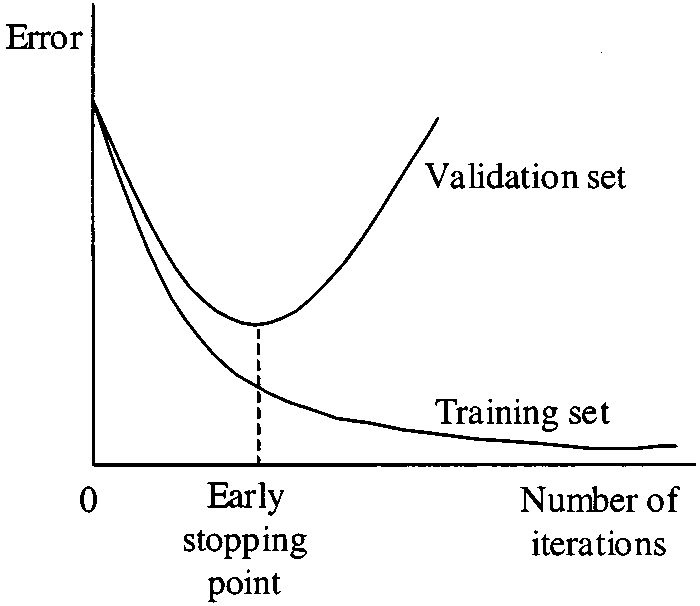
Źródło: https://www.researchgate.net/figure/Early-stopping-based-on-cross-validation_fig1_3302948

DLA CHĘTNYCH:

Na co musimy zwrócić uwagę podczas budowania zaawansowanego modelu:

Problem: zanikające / eksplodujące gradienty (propagacja wsteczna)

Rozwiązanie: inicjalizacja wag Glorota / He / LeCuna

Rozwiązanie: nienasycające funkcje aktywacji ELU / SELU

Rozwiązanie: Normalizacja wsadowa

Problem: Czasochłonne uczenie bardzo dużych sieci Deep Neural Network (DNN)

Rozwiązanie: Wielokrotne stosowanie gotowych warstw wytrenowanych na prostszych zadaniach

Rozwiązanie: Szybsze optymalizatory Adam / Nadam

Rozwiązanie: Harmonogrowanie lr stałoprzedziałowe / wydajnościowe / 1cycle

Problem: przetrenowanie

Rozwiązanie: wczesne zatrzymywanie

Rozwiązanie: regularyzacja, porzucanie neuronów, regularyzacja Monte Carlo

In [ ]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model) # opakowujemy model we wszystkie właściwości modeli Keras

In [ ]:
# siatka hiperparametrów - musimy (z pomocą biblioteki sklearn) wybrać odpowiedni zestaw
# możemy to zrobić na (3*4*3) 36 sposobów
# wytrenowanie modelu zajmuje kilka minut, a sprawdzenie wszystkich możliwości wiele godzin
# dlatego będziemy losować, żeby wybrać podencjalnie dobre hiperparametry w krótszym czasie

hiperparams = {
    "n_hidden": [1, 3, 5],
    "n_neurons": [30, 50, 100, 300],
    "learning_rate": [1e-4, 1e-3, 1e-2]
}

In [ ]:
from keras import callbacks # callbacks są przydatne podczas treningu

early_stopping_cb = callbacks.EarlyStopping(min_delta=0.001, patience=5, restore_best_weights=True)
#zatrzymaj trening jeżeli wartość funkcji straty obliczona na zbiorze walidacyjnym nie zmaleje
#o conajmniej 0.001 przez kolejnych 5 epok oraz zapisz najlepsze wagi

checkpoint_cb = callbacks.ModelCheckpoint("model.h5", save_best_only=True)
# zapisz najlepszy model

Dla chętnych: TensorBoard - do rysowania przejrzystych wykresów

https://www.tensorflow.org/tensorboard

In [ ]:
# losowe przeszukiwanie siatki hiperparametrów

from sklearn.model_selection import RandomizedSearchCV

rnd_search_cv = RandomizedSearchCV(keras_reg, hiperparams, n_iter=3, cv=3)
#cv oznacza kroswalidację

In [ ]:
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[early_stopping_cb, checkpoint_cb],
                  verbose=1)

In [ ]:
rnd_search_cv.best_params_

In [ ]:
rnd_search_cv.best_score_

In [ ]:
results = rnd_search_cv.cv_results_
for mean_score, params in zip(results["mean_test_score"], results["params"]):
    print(-mean_score, params)

In [ ]:
model = rnd_search_cv.best_estimator_.model

In [ ]:
TEST_data_filepath = '../input/tabular-playground-series-jan-2021/test.csv'
TEST_data = pd.read_csv(TEST_data_filepath)

TEST_data.columns

In [ ]:
id = TEST_data.id

In [ ]:
TEST_data = TEST_data.drop('id', axis=1)
TEST_data = scaler.transform(TEST_data)

target = model.predict(TEST_data).flatten()

In [ ]:
output = pd.DataFrame({'id': id,
                      'target': target})
output.to_csv('submission.csv', index=False)